# Salem paper attacks

This notebook showcases the three different scenarios presented in Salem *et al.* [ML-Leaks: Model and Data Independent Membership Inference Attacks and Defenses on Machine Learning Models](https://arxiv.org/abs/1806.01246).

In summary the three presented adversaries are as follows:
1. The attacker has access to a dataset drawn from the same distribution as the target data, and uses it to train a single shadow model that infers the membership information.
2. The attacker uses a dataset from a different distribution than the target data to do the same as Adv 1.
3. The attacker queries the target model and chooses a threshold on the classification probability to determine membership, no shadow models required.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Scikit-learn utils
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, make_moons
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Tensorflow imports
# import tensorflow as tf
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Input, Dense, Dropout

# Classifiers for attack models
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

### Definition of the datasets
1. We draw data points from a distribution.
2. We split these data points into the target dataset and a shadow dataset drawn from the same distribution.
3. We also draw a dataset from a different distribution.

**NOTE**. ***I make datasets with few samples but with many features to force the target model to overfit.***

In [2]:
n_classes = 2

# (X,y): Original distribution
X, y = make_classification(n_samples=10000,
                           n_classes=n_classes, 
                           n_features=50,
                           n_informative=50,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=15
                          )
# One-hot encoding of the label
y = np.eye(n_classes)[y]

# (Xt, yt) is the target dataset, owned by the TRE and drawn from the (X,y) distribution
# (Xs, ys) is a shadow dataset drawn from the (X,y) distribution
Xt, Xs, yt, ys = train_test_split(X, y, test_size=0.50, random_state=15)

# (Xd, yd) is a shadow dataset, drawn from a different distribution (different seed)
Xd, yd = make_classification(n_samples=10000,
                           n_classes=n_classes, 
                           n_features=50,
                           n_informative=50,
                           n_redundant=0,
                           n_repeated=0,
                           random_state=42
                          )
yd = np.eye(n_classes)[yd]

### Train the target model

*Again, I'm using a rather big model (for the classification task) to favour overfitting.*

In [3]:
# Split into train (member) and test (non-member) datasets
# Set shuffle to False so that Xt_membership is consistent with Xt, otherwise
# we need to stack Xt_member and Xt_nonmember again to get a consistent Xt.
Xt_member, Xt_nonmember, yt_member, yt_nonmember = train_test_split(Xt, yt, test_size=0.5, shuffle=False)

# Set membership status for future tests
Xt_membership = np.vstack(
    (
        np.ones((Xt_member.shape[0], 1), np.uint8),
        np.zeros((Xt_nonmember.shape[0], 1), np.uint8)
    )
).flatten()

# # Define target model
# # Tensorflow model (MLP) (making it big to make it overfit)
# input_data = Input(shape = Xt_member[0].shape)
# x = Dense(128, activation='relu')(input_data)
# x = Dense(128, activation='relu')(x)
# x = Dense(64, activation='relu')(x)
# output = Dense(2, activation='softmax')(x)

# target_model = Model(input_data, output)
# target_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Define target model
# # Sklearn model (MLP) (making it big to make it overfit)
target_model = MLPClassifier(hidden_layer_sizes=(128,128,64), 
                             activation='relu', 
                             solver='sgd', 
                             alpha=0.0,
                             batch_size=32,
                             learning_rate='constant',
                             learning_rate_init=0.001,
                             max_iter=10,
                             shuffle=True,
                             random_state=42,
                             verbose=True)

# Train target model
# r = target_model.fit(Xt_member, 
#                      yt_member, 
#                      validation_data=(Xt_nonmember, yt_nonmember),
#                      epochs=10, 
#                      batch_size=32
#                     )  

target_model.fit(Xt_member, yt_member)

Iteration 1, loss = 1.10284081
Iteration 2, loss = 0.64076233


Iteration 3, loss = 0.46655928
Iteration 4, loss = 0.36182417


Iteration 5, loss = 0.28458307
Iteration 6, loss = 0.22891272


Iteration 7, loss = 0.18282283
Iteration 8, loss = 0.14403744


Iteration 9, loss = 0.11536374
Iteration 10, loss = 0.09306161


C:\Users\ablancoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.0, batch_size=32, hidden_layer_sizes=(128, 128, 64),
              max_iter=10, random_state=42, solver='sgd', verbose=True)

In [4]:
target_model.score(Xt_member, yt_member)

0.9944

In [5]:
target_model.score(Xt_nonmember, yt_nonmember)

0.9396

**SUCCESS. The model overfits a lot.**

TOWARDS MODEL INDEPENDENT MEMBERSHIP INFERENCE ATTACKS (ADVERSARY 1)
In this section, we describe our first adversary considered for membership inference attack. For this adversary, we mainly relax the assumption on her shadow model design. In consequence, membership inference attack can be performed in a much more efficient and less costly way.

We start by defining the threat model. Then, we describe our first simplification, i.e., using one shadow model instead of multiple. In the end, we propose our second simplification which frees the adversary from knowing the target model’s structure.

Threat Model
We define our attack model A as a supervised ML classifier with binary classes (member or non-member). To train A, the adversary needs to derive the labeled training data. i.e., the ground truth membership. The adversary only has black-box access to the target model, i.e., she is not able to extract the membership status from the target model. Therefore, the adversary trains a shadow model to mimic the behavior of the target model, and relies on the shadow model to obtain the ground truth membership to train A.

To train the shadow model, we assume that the adversary has a dataset, denoted by (Xs,ys), that comes from the same underlying distribution as the training data for the target model. Note that most of the experiments by Shokri et al. make the same assumption. We further assume that the shadow model uses the same ML algorithm and has the same hyperparameters as the target model. To achieve this in practice, the adversary can either rely on the same MLaaS provider which builds the target model or perform model extraction to approximate the target model. Later in this section, we show this assumption can be relaxed as well.

One Shadow Model
Methodology. The adversary’s methodology can be organized into three stages, i.e., shadow model training, attack model training, and membership inference.

Shadow Model Training. The adversary first splits her dataset, i.e., (Xs,ys), into two disjoint sets, namely (Xs_train,ys_train) and (Xs_out,ys_out). Then, she uses (Xs_train,ys_train) to train her only shadow model, denoted by shadow_model.

In [6]:
# Split shadow dataset
Xs_train, Xs_out, ys_train, ys_out = train_test_split(Xs, ys, test_size=0.5)
                    
# Train shadow model  
# This model is deliberately different from the target model.
# input_data = Input(shape = Xs_train[0].shape)
# x = Dense(128, activation='relu')(input_data)
# x = Dense(64, activation='relu')(x)
# output = Dense(2, activation='softmax')(x)

# shadow_model1 = Model(input_data, output)
# shadow_model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

shadow_model1 = MLPClassifier(hidden_layer_sizes=(128,64), 
                             activation='relu', 
                             solver='sgd', 
                             alpha=0.0,
                             batch_size=32,
                             learning_rate='constant',
                             learning_rate_init=0.001,
                             max_iter=10,
                             shuffle=True,
                             random_state=42,
                             verbose=True)

# r = shadow_model1.fit(Xs_train, 
#                       ys_train, 
#                       validation_data=(Xs_out, ys_out),
#                       epochs=10, 
#                       batch_size=32
#                      )     

shadow_model1.fit(Xs_train, ys_train)

Iteration 1, loss = 1.22312219
Iteration 2, loss = 0.56726016
Iteration 3, loss = 0.42246647
Iteration 4, loss = 0.34099230
Iteration 5, loss = 0.27772162
Iteration 6, loss = 0.23250372
Iteration 7, loss = 0.19470372
Iteration 8, loss = 0.16269145
Iteration 9, loss = 0.13762144


Iteration 10, loss = 0.11482842


C:\Users\ablancoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.0, batch_size=32, hidden_layer_sizes=(128, 64),
              max_iter=10, random_state=42, solver='sgd', verbose=True)

*Attack Model Training.* The adversary uses the trained `shadow_model` to perform prediction over all data points in `(Xs,ys)` (consisting of `(Xs_train,ys_train)` and `(Xs_out,ys_out)`), and obtain the corresponding posterior probabilities. For each data point in `(Xs,ys)`, she takes its three largest posteriors (ordered from high to low) or two in the case of binary-class datasets as its feature vector. A feature vector is labeled as 1 (member), if its corresponding data point is in `(Xs_train,ys_train)`, and as 0 (nonmember) otherwise. All the generated feature vectors and labels are then used to train the attack model `attack_model`.

In [7]:
# Get prediction probabilities from the shadow model 
Xs_proba = np.vstack(
    (
        shadow_model1.predict_proba(Xs_train),
        shadow_model1.predict_proba(Xs_out)
    )
)
# Sort (only ascending order allowed)
Xs_proba = np.sort(Xs_proba, axis=1)
# Flip to get arrays sorted in descending order
Xs_proba = np.flip(Xs_proba, axis=1)

# Membership labels
Xs_membership = np.vstack(
    (
        np.ones((Xs_train.shape[0], 1), np.uint8),
        np.zeros((Xs_out.shape[0], 1), np.uint8)
    )
).flatten()

attack_model1 = MLPClassifier(hidden_layer_sizes=[32,32], activation='relu', solver='adam', max_iter=300)
attack_model1.fit(Xs_proba, Xs_membership)

MLPClassifier(hidden_layer_sizes=[32, 32], max_iter=300)

Membership Inference. To perform the attack on whether x_target is in (Xt, yt), the adversary queries target_model with x_target to obtain the corresponding posteriors. Then, she picks the 3 maximal posteriors, again ordered from high to low, and feed them into attack_model to obtain the membership prediction.

It is important to note that our adversary only uses one shadow model and one attack model in her attack, while the approach by Shokri et al. [38] adopts multiple shadow models as well as multiple attack models (one for each class). In particular, as each shadow model is established through MLaaS [38], this strategy will largely reduce the cost of her membership inference attack.

              precision    recall  f1-score   support

   nonmember     0.6266    0.1900    0.2916      2500
      member     0.5226    0.8868    0.6577      2500

    accuracy                         0.5384      5000
   macro avg     0.5746    0.5384    0.4746      5000
weighted avg     0.5746    0.5384    0.4746      5000



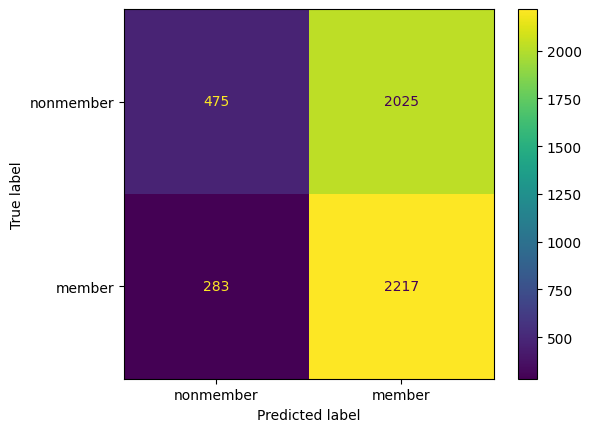

In [8]:
# Query target model with all Xt, which includes members and nonmembers, to get probabilities
Xt_proba = target_model.predict_proba(Xt)
# Order from highest to lowest
Xt_proba = np.sort(Xt_proba, axis=1)
Xt_proba = np.flip(Xt_proba, axis=1)

# Membership predictions from attack model 
Xt_membership_predictions = attack_model1.predict(Xt_proba)

# Show attack stats
print(classification_report(Xt_membership, Xt_membership_predictions, target_names=['nonmember', 'member'], digits=4))
cm = confusion_matrix(Xt_membership, Xt_membership_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['nonmember', 'member'])
disp.plot()
plt.show()

### TOWARDS DATA INDEPENDENT MEMBERSHIP INFERENCE ATTACKS (ADVERSARY 2)

In this section, we relax the assumption on the adversary having a dataset that comes from the same distribution as the
target model’s dataset.

We start by explaining the threat model, then describe the adversary’s attack methodology. In the end, we present a comprehensive experimental evaluation.


#### Threat Model
Different from the threat model in Section III, we remove the assumption that the adversary has a dataset `(Xs,ys)` coming from the same distribution as the training data for the target model. We will use the dataset `(Xd,yd)` which comes from a different distribution. This largely reduces the attack capabilities of the adversary. For this scenario, Shokri et al. propose to query the target model multiple times to generate synthetic data to train the shadow model. However, this approach can only be applied when the dataset is assembled with binary features. In contrast, our approach can be applied to attack ML models trained on any kind of data.


#### Methodology
The strategy of the second adversary is very similar to the one of the first adversary. The only difference is that the
second adversary utilizes an existing dataset that comes from a different distribution than the target model’s training data to train her shadow model. We refer to this attack as the data transferring attack.

The shadow model here is not to mimic the target model’s behavior, but only to summarize the membership status of a
data point in the training set of a machine learning model. As only the three - or two in case of binary datasets - largest
posteriors are used for the attack model, we can also neglect the effect brought by datasets with different number of classes.

In [9]:
# Split dataset
Xd_train, Xd_out, yd_train, yd_out = train_test_split(Xd, yd, test_size=0.5)
                    
# # Train shadow model    
# input_data = Input(shape = Xd_train[0].shape)
# x = Dense(128, activation='relu')(input_data)
# x = Dense(64, activation='relu')(x)
# output = Dense(2, activation='softmax')(x)

# shadow_model2 = Model(input_data, output)
# shadow_model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

shadow_model2 = MLPClassifier(hidden_layer_sizes=(128,64), 
                             activation='relu', 
                             solver='sgd', 
                             alpha=0.0,
                             batch_size=32,
                             learning_rate='constant',
                             learning_rate_init=0.001,
                             max_iter=10,
                             shuffle=True,
                             random_state=42,
                             verbose=True)

# r = shadow_model2.fit(Xd_train, 
#                       yd_train, 
#                       validation_data=(Xd_out, yd_out),
#                       epochs=10, 
#                       batch_size=32
#                      ) 

shadow_model2.fit(Xd_train, yd_train)

Iteration 1, loss = 1.14609761
Iteration 2, loss = 0.58821606
Iteration 3, loss = 0.40310547


Iteration 4, loss = 0.29354889
Iteration 5, loss = 0.22447765


Iteration 6, loss = 0.18036933
Iteration 7, loss = 0.14967641
Iteration 8, loss = 0.12881076


Iteration 9, loss = 0.10862406
Iteration 10, loss = 0.09335933


C:\Users\ablancoj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.0, batch_size=32, hidden_layer_sizes=(128, 64),
              max_iter=10, random_state=42, solver='sgd', verbose=True)

*Attack model training.* 

In [10]:
# Get probabilities 
Xd_proba = np.vstack(
    (
        shadow_model2.predict_proba(Xd_train),
        shadow_model2.predict_proba(Xd_out)
    )
)
# Sort (only ascending order allowed)
Xd_proba = np.sort(Xd_proba, axis=1)
# Flip to get array sorted in descending order
Xd_proba = np.flip(Xd_proba, axis=1)

Xd_membership = np.vstack(
    (
        np.ones((Xd_train.shape[0], 1), np.uint8),
        np.zeros((Xd_out.shape[0], 1), np.uint8)
    )
).flatten()

attack_model2 = MLPClassifier(hidden_layer_sizes=[32,32], activation='relu', solver='adam', max_iter=300)
attack_model2.fit(Xd_proba, Xd_membership)

MLPClassifier(hidden_layer_sizes=[32, 32], max_iter=300)

              precision    recall  f1-score   support

   nonmember     0.6449    0.1460    0.2381      2500
      member     0.5185    0.9196    0.6631      2500

    accuracy                         0.5328      5000
   macro avg     0.5817    0.5328    0.4506      5000
weighted avg     0.5817    0.5328    0.4506      5000



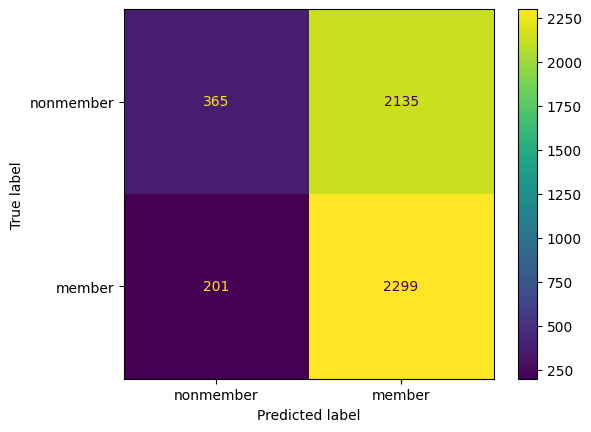

In [11]:
# Query target model with all Xt, which includes members and nonmembers, to get probabilities
Xt_proba = target_model.predict_proba(Xt)
# Order from highest to lowest
Xt_proba = np.sort(Xt_proba, axis=1)
Xt_proba = np.flip(Xt_proba, axis=1)

# Membership predictions 
Xt_membership_predictions = attack_model2.predict(Xt_proba)

# Show attack stats
print(classification_report(Xt_membership, Xt_membership_predictions, target_names=['nonmember', 'member'], digits=4))
cm = confusion_matrix(Xt_membership, Xt_membership_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['nonmember', 'member'])
disp.plot()
plt.show()

### MODEL AND DATA INDEPENDENT MEMBERSHIP INFERENCE ATTACK WITHOUT TRAINING (ADVERSARY 3)

In this section, we present our third adversary, who does not need to train any shadow model and does not assume knowledge of model or data distribution. We start with the threat model description. Then, we list the attack methodology. In the end, we present the evaluation results.


#### A. Threat Model
We relax the assumption that the adversary needs to train any shadow model to perform her attack. All she could rely on is the target model’s output posteriors `target_model.predict(Xt)` after querying her target data point `x_target`. Note that  Yeom et al. propose a similar attack, however, their membership inference attack requires the adversary to know the target data point’s class label which is hard to obtain in some cases, such as in biomedical settings. Therefore, our threat model
covers a broader range of scenarios.


#### B. Methodology
The attack model for the third adversary is implemented as an unsupervised binary classification. Concretely, the adversary
first obtains `target_model.predict(x_target)`. Then, she extracts the highest posterior and compares whether this maximum is above a certain threshold. If the answer is yes, then she predicts the data point is in the training set of the target model and vice versa. The reason we pick maximum as the feature follows the reasoning that an ML model is more confident, *i.e.*, one posterior is much higher than others, when facing a data point that it was trained on. In another words, the maximal posterior of a member data point is much higher than the one of a non-member data point.

**Threshold Choosing.** The attacker can pick the threshold for membership inference depending on her requirements, as in
many machine learning applications. For instance, if she concentrates more on inference precision (recall), then she
can pick a relatively high (low) threshold.

Nevertheless, we provide a general method for choosing a threshold. Concretely, we generate a sample of random points in the feature space of the target data point. For image datasets including CIFAR-10, CIFAR-100, MNIST, and Face, we generate random images, where the value of each pixel is drawn from a uniform distribution. For datasets with binary features including Location and Purchase datasets, we generate 0 and 1 for each feature according to an unbiased coin flip.
For Adult and News, as the bounds for features are not clear, our method cannot apply. One way to tackle this is to collect
News articles or people’s records (with the same features as in the Adult dataset) from the Internet as the “random” points. We leave this for future work. Next, we query these random points to the target model to get the corresponding maximal posteriors. We hypothesize that these points act as the nonmember points. Thus, top t percentile of these random points’ maximal posteriors can serve as a good threshold. Below, we show empirically that there exists a choice of t percentile that works well and generalizes across all the dataset and therefore can be used to automatically determine the detection threshold.

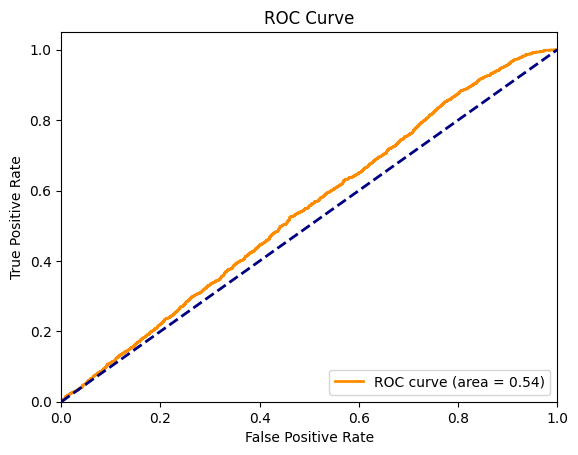

              precision    recall  f1-score   support

   nonmember     0.6051    0.2268    0.3299      2500
      member     0.5242    0.8520    0.6491      2500

    accuracy                         0.5394      5000
   macro avg     0.5647    0.5394    0.4895      5000
weighted avg     0.5647    0.5394    0.4895      5000



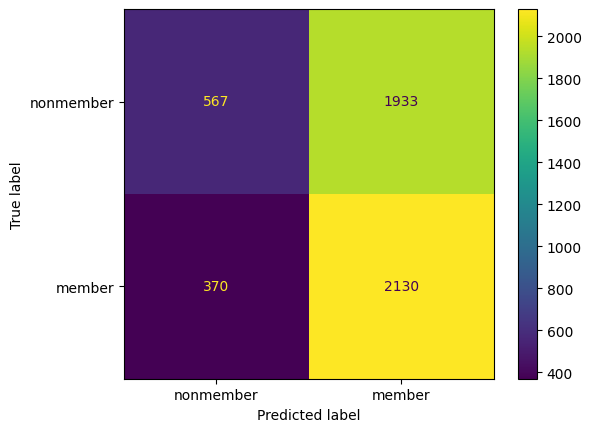

In [12]:
# Query target model with all Xt, which includes members and nonmembers, to get probabilities
Xt_probs = target_model.predict_proba(Xt)
# Get array of max probabilities
Xt_max_probs = np.amax(Xt_probs, axis=1)
# Test for thresholds
fpr, tpr, thresholds = roc_curve(Xt_membership, Xt_max_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color="darkorange", lw=lw, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


# Find threshold with max advantage
adv = np.abs(tpr-fpr)
max_adv_idx = np.argmax(adv)
opt_threshold = thresholds[max_adv_idx]

# Attack with best threshold
Xt_membership_predictions = np.where(Xt_max_probs >= opt_threshold, 1, 0)
# Show attack stats
print(classification_report(Xt_membership, Xt_membership_predictions, target_names=['nonmember', 'member'], digits=4))
cm = confusion_matrix(Xt_membership, Xt_membership_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['nonmember', 'member'])
disp.plot()
plt.show()